Author: Jules Deschamps

This notebook showcases a comprehensive walkthrough of the Climate-Extended Risk Model (CERM) and its implementation.

## Packages imports

In a first place we import all the necessary packages.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Class imports and main parameters

Then, we need to import all required classes:

- __Portfolio__ is the class representing portfolios, which are to be input in the CERM.

In [5]:
from Portfolio import Portfolio, load_from_file, show

For the following, we will use a template portfolio. We can access that portfolio like this:

In [6]:
portfolio_path = 'portfolio1000loans.dump'
portfolio = load_from_file(portfolio_path)

Portfolio loaded ( 0:00:00.011063 )


More details on how to create or edit portfolios can be found in the __Portfolio__ file.

Next:

- __Ratings__ is the class of chosen ratings.

The choice of ratings can be represented with a single square matrix, with as many indices as ratings. This particular regulatory ratings matrix has 8 ratings, from 'AAA' to 'D', 'D' being default (this matrix is drawn from S&P 1996).

In [7]:
from Ratings import TEST_8_RATINGS

ratings_table = pd.DataFrame(TEST_8_RATINGS.reg_mat())
ratings_table.index, ratings_table.columns = TEST_8_RATINGS.list(), TEST_8_RATINGS.list()
ratings_table


,AAA,AA,A,BBB,BB,B+,B,D
AAA,0.9081,0.0833,0.0068,0.0006,0.0012,0.0000,0.0000,0.0000
AA,0.0070,0.9065,0.0779,0.0064,0.0006,0.0014,0.0002,0.0000
A,0.0009,0.0227,0.9105,0.0552,0.0074,0.0026,0.0001,0.0006
BBB,0.0002,0.0033,0.0595,0.8693,0.0530,0.0117,0.0012,0.0018
BB,0.0003,0.0014,0.0067,0.0773,0.8053,0.0884,0.0100,0.0106
B+,0.0000,0.0011,0.0024,0.0043,0.0648,0.8346,0.0407,0.0520
B,0.0022,0.0000,0.0022,0.0130,0.0238,0.1124,0.6486,0.1979
D,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


For a better grasp of what we are setting as future arguments to the CERM, we shall take a look at the portfolio template.

In [8]:
portfolio_dict = show(portfolio)
print(f"These are the different loan groupings for this portfolio: \n{list(portfolio_dict.keys())}.")

These are the different loan groupings for this portfolio: 
['high stake/americas4', 'high stake/europe2', 'high stake/world3', 'high stake/europe4', 'high stake/europe1', 'high stake/world4', 'high stake/europe3', 'high stake/world1', 'world4', 'world2', 'high stake/americas2', 'high stake/americas3', 'world1', 'high stake/world2', 'world3', 'high stake/americas1'].


Here is what the loans in the group _world1_ look like at time $0$. Notably, all loans are with EAD 1000000, and a 0% recovery rate.

In [9]:
world1_loans = portfolio_dict['world1']
world1_df = pd.DataFrame(world1_loans)
world1_df.columns = ['principal', 'horizon', 'recovery_rate', 'rating']
world1_df


,principal,horizon,recovery_rate,rating
0,1000000,6,0,BBB
1,1000000,6,0,A
2,1000000,10,0,AA
3,1000000,13,0,BBB
4,1000000,8,0,AA
5,1000000,6,0,B
6,1000000,12,0,BB
7,1000000,10,0,BBB
8,1000000,10,0,AA
9,1000000,6,0,BB


We can also compute the total EAD of this portfolio at time 1. We shall note however that the portfolio is amortized and that a complementary set of loans with the following profile (in %) is added every time unit (year). This is why final losses can be greater than the principal of the portfolio.

In [10]:
loan_profile = np.array([[4,21,60,72,34,20,2,0]])/213
loan_profile_df = pd.DataFrame(loan_profile*100)
loan_profile_df.columns = TEST_8_RATINGS.list()
loan_profile_df

,AAA,AA,A,BBB,BB,B+,B,D
0,1.877934,9.859155,28.169014,33.802817,15.962441,9.389671,0.938967,0.0


The total principal of the portfolio is: $1B

In [11]:
all_loans = np.vstack(portfolio_dict.values())
all_principals = all_loans[:,0]
total_principal = sum(np.array(all_principals, dtype=np.int32))
print(f"Total principal of the portfolio is {total_principal}")

Total principal of the portfolio is 1000000000


/var/folders/9r/n9d0f4t12xx3rcgzxxzws5ph0000gp/T/ipykernel_42958/2798793762.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_loans = np.vstack(portfolio_dict.values())


Next:

- __parameters__ is a file listing the values chosen/assessed for climate evolution.

They are listed right below. For a better understanding of what these quantities represent: https://arxiv.org/abs/2205.02581.
All these quantities are open to change and this list is merely an example of what climate behaviour could be set to look like in the next years. Besides, we welcome any well-calibrated values.

In [12]:
from parameters import *

In [13]:
#time horizon of the study
horizon = 10

#transition efficiency coefficient (reduced)
alpha = .02

#transition effort reactivity coefficient
beta = 1.5

#climate change intensity of the economic activity (idiosyncratic)
gamma = .005

#hypothetical climate-free average growth rate of log GDP
R = 1

#idiosyncratic economic risk
e = .1

#idiosyncratic physical risk
p = .1

#independent transition coefficient
theta = .1

- __ScenarioGenerator__ is the class modeling the stochastic evolution of climate.

That is the class in which we are setting the climatic parameters as arguments.

For information, the climate would be set to evolve like this, with these values and under the hypotheses we have proposed in our article (where all quantities such as physical or transition risks, ... are defined):
- This first graph is the evolution of the macro-correlations of the risks considered, i.e. their relative importance, over the next decade.
- The second one presents the auto- and cross-correlations of these same risks over the next decade.

Scenarios generated ( 0:00:00.000908 )


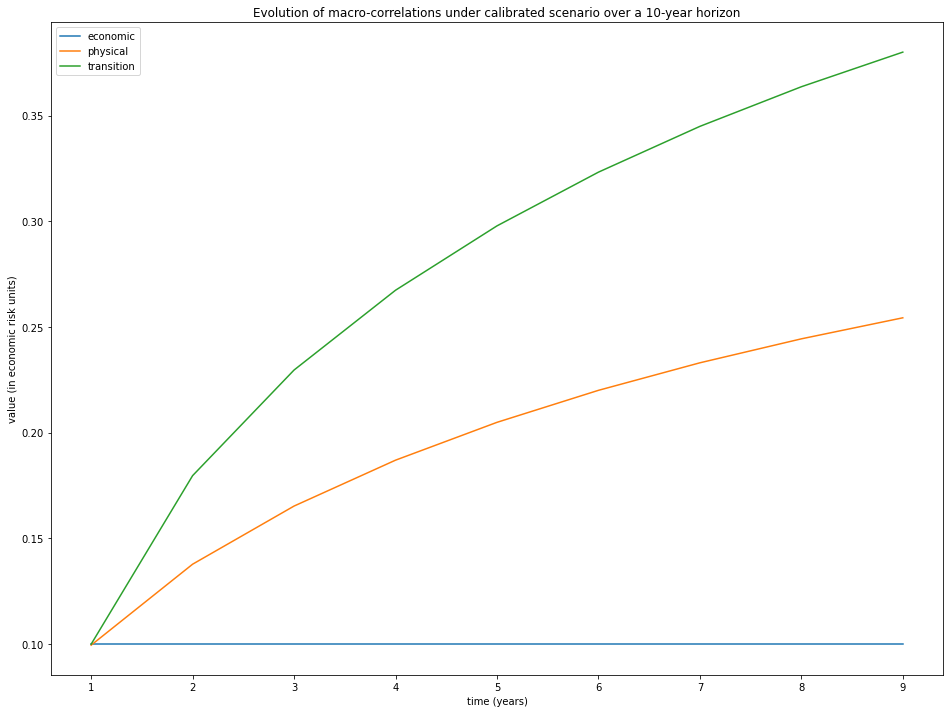

In [14]:
from ScenarioGenerator import ScenarioGenerator

scenario = ScenarioGenerator(horizon, alpha, beta, gamma, R, e, p, theta)
scenario.compute()

#logging of all macro-correlations evolutions

macros = scenario.macro_correlation.T

#plotting

plt.figure(figsize=(16,12))
plt.plot(range(1,horizon), macros[1:,:], label=["economic","physical","transition"])
plt.title("Evolution of macro-correlations under calibrated scenario over a "+str(horizon)+"-year horizon")
plt.ylabel("value (in economic risk units)")
plt.xlabel("time (years)")
plt.legend()
plt.show()

Scenarios generated ( 0:00:00.003292 )


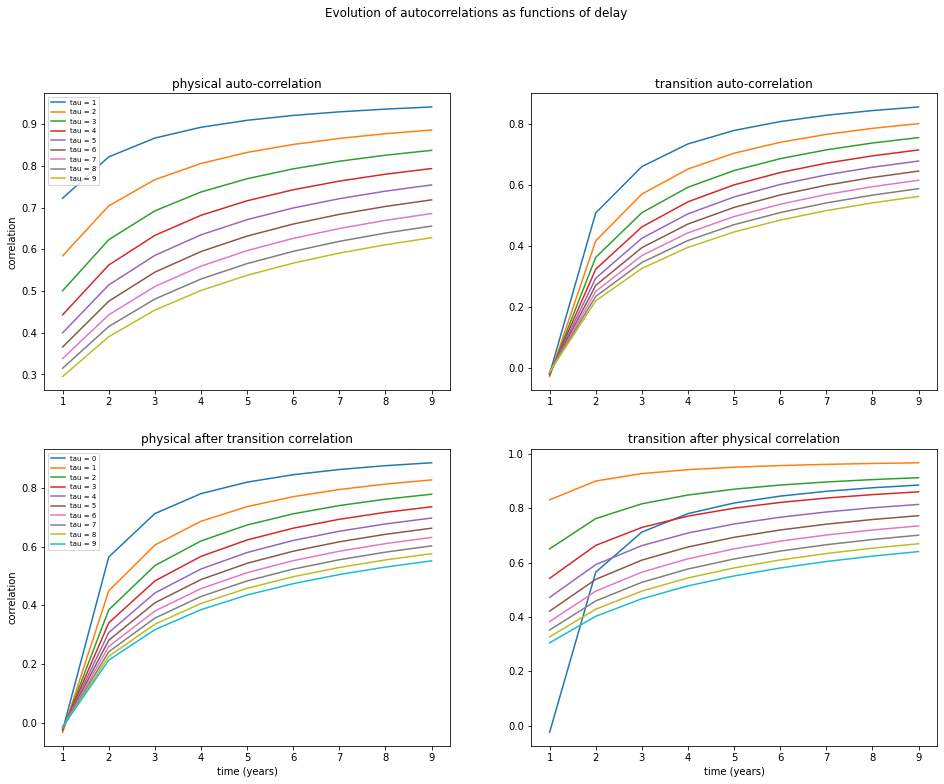

In [15]:
from utils import correlation_from_covariance

# we compute the climate scenario until 2 * horizon to get auto- and cross- correlations as delayed as the horizon

scenario_extended = ScenarioGenerator(2 * horizon, alpha, beta, gamma, R, e, p, theta)
scenario_extended.compute()

# generation of the incremental matrix

A = np.array(
    [[0, 0, 0], [-scenario.gamma, 1, -scenario.alpha], [0, scenario.beta, 0]])

# initialization of autocorrelations

autocorrelation = np.zeros(
    (horizon, horizon-1, scenario.nb_rf, scenario.nb_rf))
autocorrelation_phy = np.zeros((horizon-1, horizon-1))
autocorrelation_tra = np.zeros((horizon-1, horizon-1))
autocorrelation_phy_tra = np.zeros((horizon-1, horizon))
autocorrelation_tra_phy = np.zeros((horizon-1, horizon))

# initialization of times and delays for which is drawn the graph

times = range(1, horizon)
taus = range(1, horizon)

# execution

for t in times:

    # logging of variance matrix at time t

    var_t = scenario_extended.var_at(t)
    corr = correlation_from_covariance(var_t)

    # logging of simultaneous cross-correlations, i.e. for delay tau=0

    autocorrelation_phy_tra[t-1, 0] = corr[2, 1]
    autocorrelation_tra_phy[t-1, 0] = corr[1, 2]

    # execution for each possible delay

    for tau in taus:

        # logging of variance matrix at time t+tau

        var_delay = scenario_extended.var_at(t+tau)

        # logging of inverse [standard deviations (macro-correlations)] at times t and t+tau

        at_time = np.reshape(1/np.sqrt(np.diag(var_t)), (3, 1))
        at_delay = np.reshape(1/np.sqrt(np.diag(var_delay)), (3, 1))

        # following the formula from the paper

        invsd = (at_delay@at_time.T)
        autocorrelation = invsd*(np.linalg.matrix_power(A, tau)@var_t)

        # logging all auto- and cross-correlations

        autocorrelation_phy[t-1, tau-1] = autocorrelation[1, 1]
        autocorrelation_tra[t-1, tau-1] = autocorrelation[2, 2]
        autocorrelation_phy_tra[t-1, tau] = autocorrelation[2, 1]
        autocorrelation_tra_phy[t-1, tau] = autocorrelation[1, 2]

# plotting results

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Evolution of autocorrelations as functions of delay')

ax1.plot(times, autocorrelation_phy, label=["tau = "+str(tau) for tau in taus])
ax1.set_title('physical auto-correlation')
ax1.legend(loc="upper left", prop={"size": 7})
ax1.set_ylabel("correlation")

ax2.plot(times, autocorrelation_tra, label=["tau = "+str(tau) for tau in taus])
ax2.set_title('transition auto-correlation')

taus = [0]+list(taus)

ax3.plot(times, autocorrelation_tra_phy, label=[
         "tau = "+str(tau) for tau in taus])
ax3.set_title('physical after transition correlation')
ax3.legend(loc="upper left", prop={"size": 7})
ax3.set_ylabel("correlation")
ax3.set_xlabel("time (years)")

ax4.plot(times, autocorrelation_phy_tra, label=[
         "tau = "+str(tau) for tau in taus])
ax4.set_title('transition after physical correlation')
ax4.set_xlabel("time (years)")

plt.show()


Finally:

- __LargeCERMEngine__ is the class for the Climate-Extended Risk Model, when the sample size is so large that idiosyncratic risks can be considered negligible.



In [16]:
from LargeCERMEngine import LargeCERMEngine

## Running the model

Here, the model runs with the ratings and the portfolio we have presented above, and under the same climate scenario, too.

We are presenting three different graphs that can truly speak to the number of applications the CERM can be set out for.

In [17]:
# number of iterations for Monte-Carlo simulation

N = 10

# risk values

risk1 = .05
risk2 = .01

First, what we do is to compute as much relevant information as possible: essentially, every pertinent graph can be computed from the MC iterations of total losses at each time, and the associated risk values.

In [18]:
#computation of all losses through LCERM

engine = LargeCERMEngine(portfolio, TEST_8_RATINGS, scenario)
engine.compute(N)

#definition of risk indices matching risk1 and risk2

ind1 = int(np.floor(N*(1-risk1)))
ind2 = int(np.floor(N*(1-risk2)))

#logging of all losses

losses = engine.loss_results

#logging of final physical and transition cumulative risks (the - sign is simply so that loss distribution in the physical/transition plane is well-oriented)

cumulative_growth_factors = -engine.cumulative_growth_factors[1:, :]

#logging of final losses for plane distribution

scenario_losses = losses.sum(axis=(1,2))

#sorting of all losses, to assess the losses at risk1 and risk2

sorted_losses = np.sort(losses, axis=0)

#logging of non-cumulative expected loss, unexpected loss at risk risk1, unexpected loss at risk risk2 at each time

el, ul1, ul2 = sorted_losses.sum(axis=(0,1))/N, (sorted_losses.sum(axis=1))[ind1], (sorted_losses.sum(axis=1))[ind2]

#logging of all final losses or all iterations

draws = np.sort(losses.sum(axis=(1,2)))

#computation of cumulative expected loss, unexpected loss at risk risk1, unexpected loss at risk risk2 at each time

for t in range(1,horizon):
    el[t] += el[t-1]
    ul1[t] += ul1[t-1]
    ul2[t] += ul2[t-1]

#logging of final cumulative expected loss, unexpected loss at risk risk1, unexpected loss at risk risk2

expected_loss = el[-1]
unexpected_loss1 = ul1[-1]
unexpected_loss2 = ul2[-1]

Initializing CERM for 1000 loans in 16 groups, 8 ratings with horizon 10
Matrix and threshold generated ( 0:00:00.133850 )
Scenarios generated ( 0:00:00.001020 )
CERM computation done for iteration 0 ( 0:00:00.012999 )
Scenarios generated ( 0:00:00.001452 )
CERM computation done for iteration 1 ( 0:00:00.013196 )
Scenarios generated ( 0:00:00.001240 )
CERM computation done for iteration 2 ( 0:00:00.011721 )
Scenarios generated ( 0:00:00.001067 )
CERM computation done for iteration 3 ( 0:00:00.012225 )
Scenarios generated ( 0:00:00.000970 )
CERM computation done for iteration 4 ( 0:00:00.012134 )
Scenarios generated ( 0:00:00.001069 )
CERM computation done for iteration 5 ( 0:00:00.013738 )
Scenarios generated ( 0:00:00.000880 )
CERM computation done for iteration 6 ( 0:00:00.010744 )
Scenarios generated ( 0:00:00.000797 )
CERM computation done for iteration 7 ( 0:00:00.011371 )
Scenarios generated ( 0:00:00.001083 )
CERM computation done for iteration 8 ( 0:00:00.011195 )
Scenarios gen

/Users/u724552/Desktop/streamlitapp/amaltheafs-cerm_advanced-f2c913bc33b2/main/MatrixAndThresholdGenerator.py:244: RuntimeWarning: divide by zero encountered in true_divide
  self.conditional_thresholds = (self.thresholds - srisks_resized)/self.ratio2_resized


With all of these quantities, in the next graph we are computing the MC distribution of total losses at horizon.

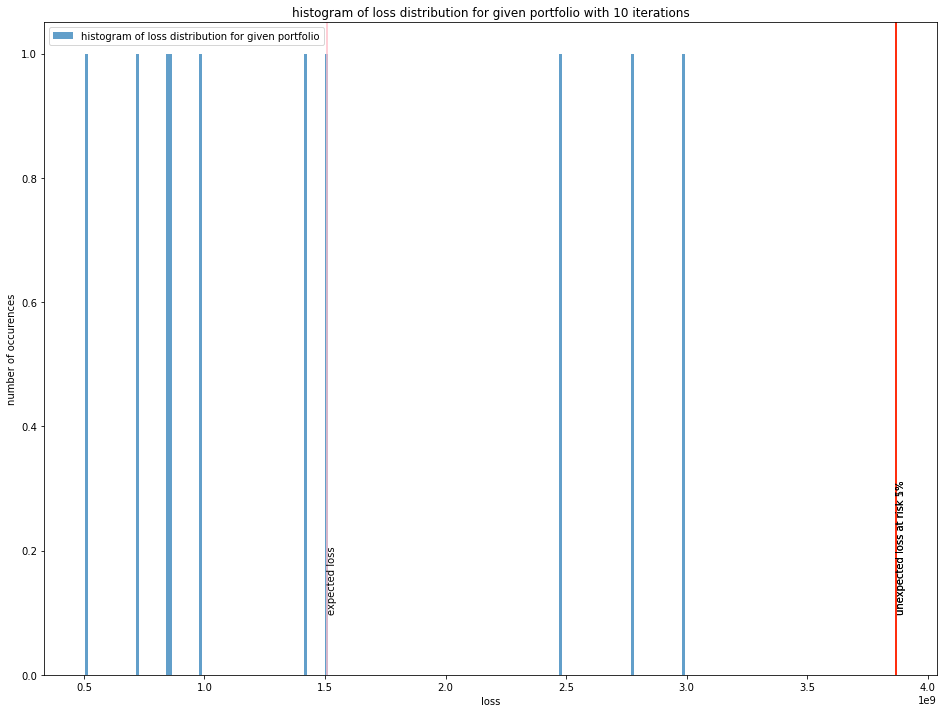

In [19]:
#plotting of final loss distribution, along with expected loss and unexpected losses at risks risk1 and risk2

plt.figure(figsize=(16, 12))
plt.hist(draws, bins=max(200, N//100), alpha=.7, label="histogram of loss distribution for given portfolio")

plt.axvline(x = expected_loss, color='pink')
plt.text(expected_loss+20, N/100,"expected loss",rotation=90)
plt.axvline(x = unexpected_loss1, color='orange')
plt.text(unexpected_loss1+20, N/100,"unexpected loss at risk "+str(int(100*risk1))+"%",rotation=90)
plt.axvline(x = unexpected_loss2, color='red')
plt.text(unexpected_loss2+20, N/100,"unexpected loss at risk "+str(int(100*risk2))+"%",rotation=90)

plt.xlabel("loss")
plt.ylabel("number of occurences")
plt.title("histogram of loss distribution for given portfolio with "+str(N)+" iterations")

plt.legend()
plt.show()

Here, we are plotting the evolution of the estimates of the expected loss, and the 5% and 1% unexpected losses.

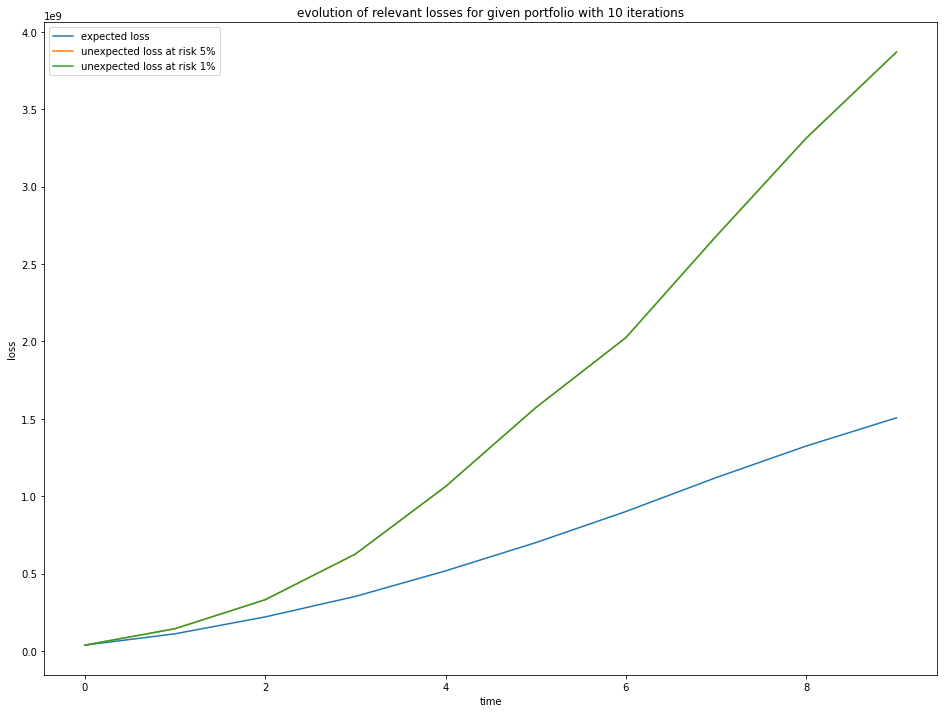

In [20]:
#plotting of evolution of expected loss and unexpected losses at risks risk1 and risk2

plt.figure(figsize=(16,12))
plt.plot(el, label="expected loss")
plt.plot(ul1, label="unexpected loss at risk "+str(int(100*risk1))+"%")
plt.plot(ul2, label="unexpected loss at risk "+str(int(100*risk2))+"%")

plt.xlabel("time")
plt.ylabel("loss")
plt.title("evolution of relevant losses for given portfolio with "+str(N)+" iterations")

plt.legend()
plt.show()

And finally, here we are plotting all losses in the physical/transition plane.

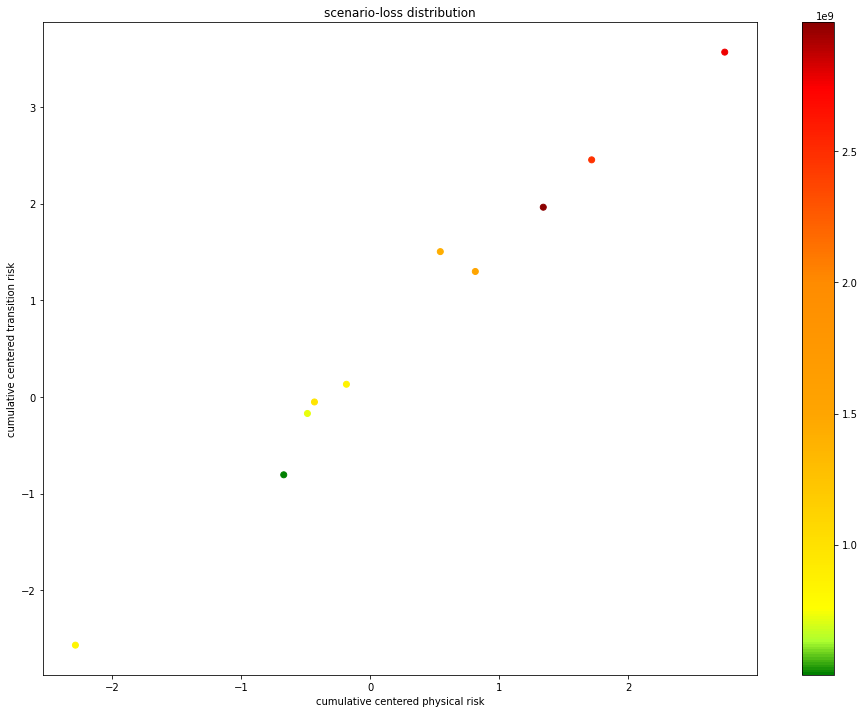

In [21]:
#plotting of loss-scenario (physical and transition) distribution

plt.figure(figsize=(16,12))

c = ["green", "greenyellow", "yellow", "orange", "darkorange", "red", "darkred"]
v = [0,.05,.1,.4,.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

plt.scatter(cumulative_growth_factors[0], cumulative_growth_factors[1], c=scenario_losses, cmap=cmap, label="data point")

plt.xlabel("cumulative centered physical risk")
plt.ylabel("cumulative centered transition risk")
plt.title("scenario-loss distribution")
plt.colorbar()

plt.show()

Of course, one can play around with the climate coefficients or with the portfolio at hand to see how they influence the loss distribution.

N.B.: There are many more possible uses of the LCERM, some of which can be found in the 'plus' folder for example. Unfortunately, many of these examples have been implemented for former versions of the CERM and they might be outdated (for example, losses w/ and wo/ climate effort, regression of losses against climate parameters, ...)

If you have any questions, feel free to contact me at jules.deschamps@student-cs.fr.